# Project 2: Steam Review Analysis

Steam is one of the largest digital game distributors on the market, offering a massive amount of games, and providing a platform for anyone to publish them. It supports community-driven features, such as game reviews, recommendations, and modding for those games. The platform generates a ton of data, with the dataset I'm analyzing having over 41 million user reviews.

The dataset was pulled from [Kaggle](), and was last updated around August 2024. The data offers information on a massive amount of games, giving information on game titles, review data, pricing, operating systems, and more. It provides a good source of info to answer some questions on users of the platform and game performance. 

**Primary Question: Does the number of user reviews correlate with a game's rating?** 

**Observations to Explore:** 
1. Does the discount on a game correlate with the number of reviews?
2. Do games that support multiple operating systems have a better ratio of positive reviews?
3. Does release date have an impact on review count?

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

## Primary Question

In [67]:
steamGameData = pd.read_csv('steam/games.csv')
steamGameData

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True


In [68]:
steamGameData.dropna(inplace=True)
steamGameData

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True


In [69]:
def classify_steam_reviews(row):
    ratio = row['positive_ratio']
    reviews = row['user_reviews']
    
    if ratio >= 0.95 and reviews >= 500:
        return 'overwhelmingly positive'
    elif ratio >= 0.85 and reviews >= 50:
        return 'very positive'
    elif ratio >= 0.80 and reviews >= 1:
        return 'positive'
    elif ratio >= 0.70 and reviews >= 1:
        return 'mostly positive'
    elif ratio >= 0.40 and reviews >= 1:
        return 'mixed'
    elif ratio >= 0.20 and reviews >= 1:
        return 'mostly negative'
    elif ratio < 0.20 and reviews >= 500:
        return 'overwhelmingly negative'
    elif ratio < 0.20 and reviews >= 50:
        return 'very negative'
    else:
        return 'negative'

steamGameData['rating'] = steamGameData.apply(classify_steam_reviews, axis=1)

In [70]:
x = steamGameData[['user_reviews', 'price_final', 'positive_ratio', 'discount']]
y = steamGameData['rating']

In [71]:
if not steamGameData.empty and len(steamGameData) > 1:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
else:
    print("dataset doesnt work")


In [72]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'accuracy: {accuracy:.5f}')
print('classification report:')
print(report)

accuracy: 1.00000
classification report:
                         precision    recall  f1-score   support

               negative       1.00      1.00      1.00         2
overwhelmingly positive       1.00      1.00      1.00      1563
               positive       1.00      1.00      1.00      5123
          very positive       1.00      1.00      1.00      3487

               accuracy                           1.00     10175
              macro avg       1.00      1.00      1.00     10175
           weighted avg       1.00      1.00      1.00     10175



In [73]:
# cross-validating bc accuracy is 1.00
cv_scores = cross_val_score(clf, x, y, cv=5)

print(f'crossval scores: {cv_scores}')
print(f'crossval accuracy (average): {cv_scores.mean():.5f}')

crossval scores: [1. 1. 1. 1. 1.]
crossval accuracy (average): 1.00000


In [74]:
feature_importance = clf.feature_importances_
for feature, importance in zip(x.columns, feature_importance):
    print(f'feature: {feature}, importance: {importance:.5f}')

feature: user_reviews, importance: 0.96368
feature: price_final, importance: 0.01472
feature: positive_ratio, importance: 0.02135
feature: discount, importance: 0.00025


### Evaluation

At the moment, it seems like the model I used overfits the data. I believe this is due to the way the dataset is organized, where reviews directly relate to the rating. I'm going to have to go back through and find a way to fix this issue.

At the moment, it seems like user_reviews, which lists the quantity of those reviews, has the highest importance. Therefore, we can assume the quantity determines how important a review is.

### Visualizations

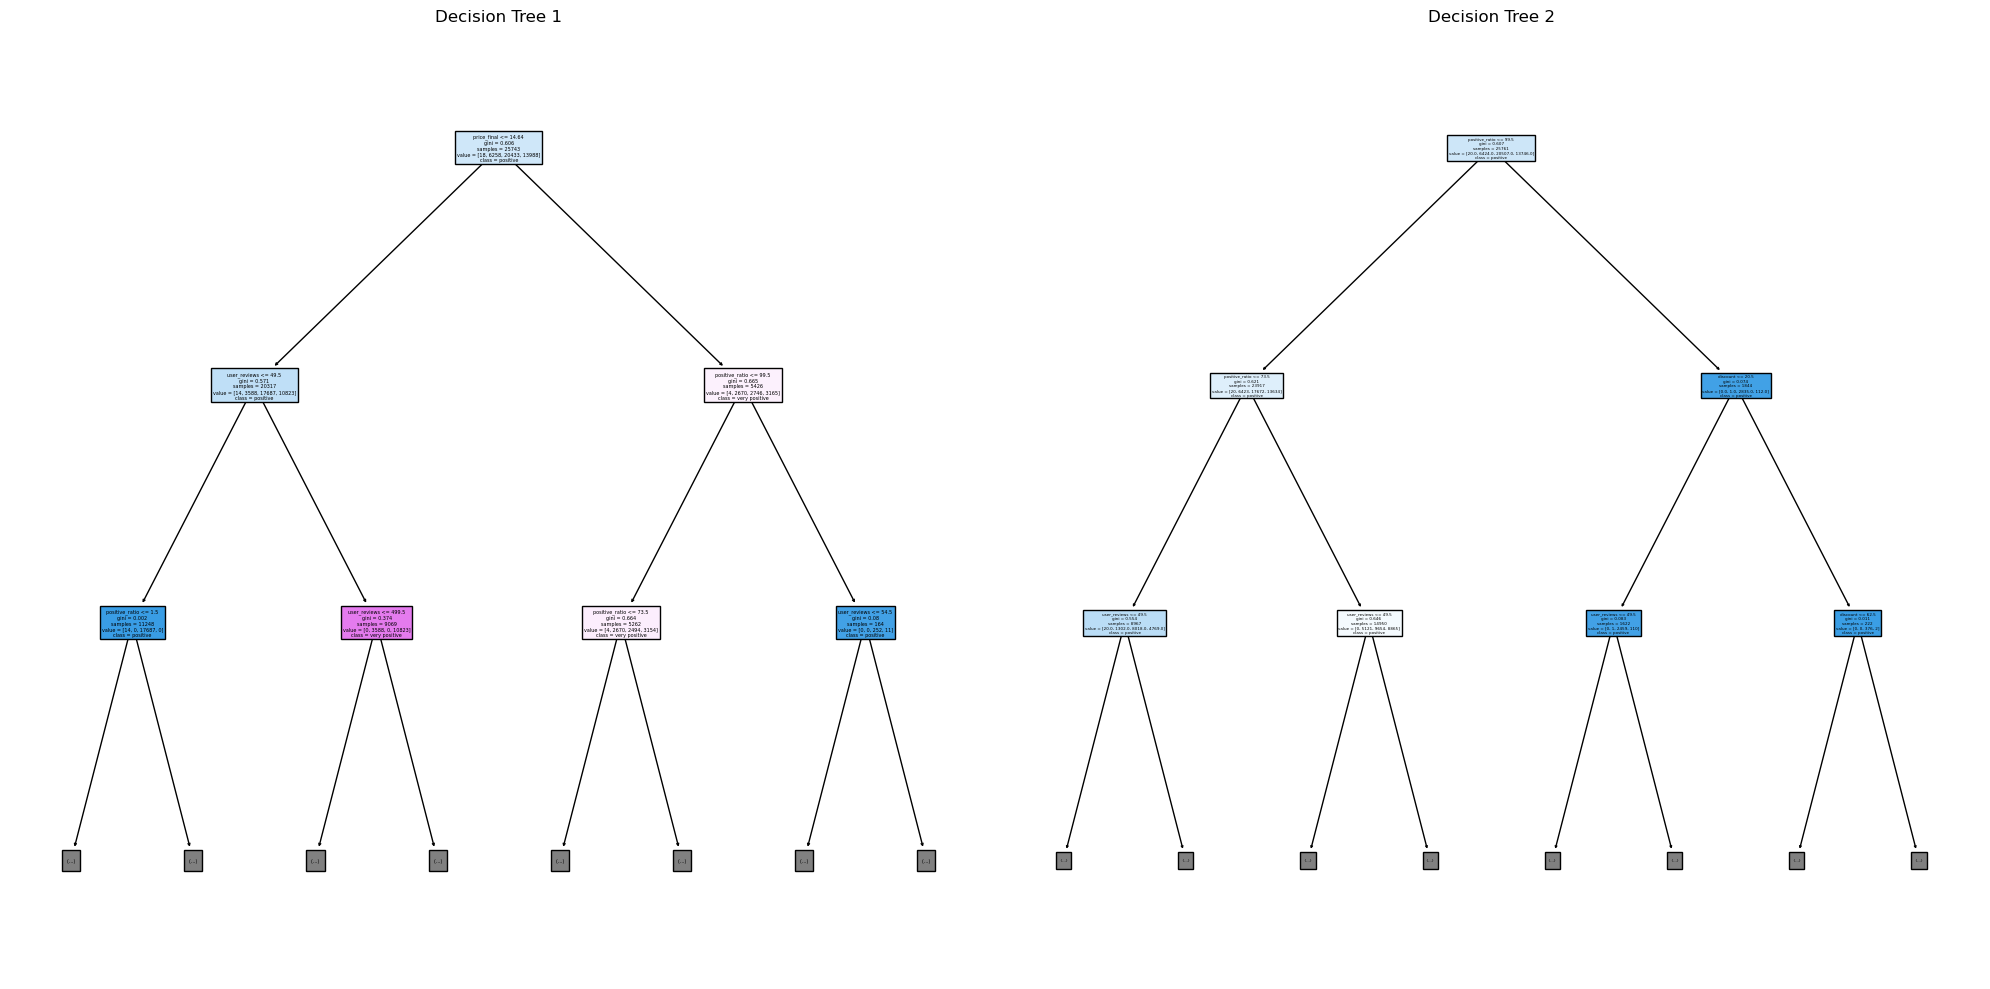

In [82]:
plt.figure(figsize=(20, 10))

tree_count = 2
max_depth = 2

for i in range(tree_count):
    plt.subplot(1, tree_count, i + 1)
    plot_tree(clf.estimators_[i], feature_names=x.columns, class_names=clf.classes_, filled=True, max_depth=max_depth)
    plt.title(f'Decision Tree {i + 1}')
plt.tight_layout()
plt.show()